# Predicting Ground Water Levels with Kernel Regression

In [1]:
from __future__ import absolute_import, division, print_function

import os
import json
import pyro
import torch
import pickle
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import pyro.optim as optim
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt
import pyro.distributions as dist
import matplotlib.animation as animation

from torch.distributions import constraints

from functools import partial
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image, Video
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO

pyro.set_rng_seed(0)

In [2]:
%matplotlib inline
logging.basicConfig(format="%(message)s", level=logging.INFO)

# Enable validation checks
pyro.enable_validation(True)
smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("0.4.1")

In [3]:
pyro.set_rng_seed(1)

In [4]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [5]:
#open from file
file = open('preprocessing/dataset.pkl', 'rb')
x_farm = pickle.load(file)
y_farm = pickle.load(file)
x_well= pickle.load(file)
y_well= pickle.load(file)


file.close()

## Helper Functions

In [6]:
def pairwise_distances(x, y=None):
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    dist = torch.clamp(dist, 0.0, np.inf)
    
    return dist

In [7]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [8]:
def visualize_posterior(samples):
    import math
    
    sites = list(samples.keys())
    
    r = int(math.ceil(math.sqrt(len(samples))))
    fig, axs = plt.subplots(nrows=r, ncols=r, figsize=(15, 13))
    fig.suptitle("Marginal Posterior Density", fontsize=16)
    
    
    for i, ax in enumerate(axs.reshape(-1)):
        if i >= len(sites):
            break
        site = sites[i]
        sns.distplot(samples[site], ax=ax)
        ax.set_title(site)
        
    handles, labels = ax.get_legend_handles_labels()

## Loading Data

In [9]:
data = pd.read_csv("data/sample_data.csv", encoding="ISO-8859-1")

data_wells = data[data.type == "well"]
data_farms = data[data.type == "farm"]

XW, YW = [], []
for t in data_wells["timestep"].unique():
    data_ = data_wells[data_wells["timestep"] == t]

    XW.append(data_[["latitude", "longitude"]].values)
    YW.append(data_["observation"].values)
    
XW = XW[0]

XF = data_farms[["latitude", "longitude"]].values
YF = data_farms["observation"].values

FileNotFoundError: [Errno 2] File b'data/sample_data.csv' does not exist: b'data/sample_data.csv'

In [57]:
plt.clf()
fig = plt.figure(figsize=(10, 10), dpi=100)

plt.ion()

plt.scatter(XF[:, 0], XF[:, 1], marker="s", s=7, color="lightgreen")

scat = plt.scatter(XW[:, 0], XW[:, 1], marker="s", s=20, c=[(0, 0, 0, 1)] * len(XW))
label = plt.text(0, 0, '', fontsize=12)

colors = []
for obs in YW:
#     min_v = min(obs)
#     max_v = max(obs)
#     colors.append([max((x - min_v) / (max_v - min_v), 0.1) for x in obs])
    colors.append([min(1 - abs(x) / 15, 1) for x in obs])
    
colors = np.array(colors)

def update_plot(i, scat):
    scat.set_array(colors[i])
    label.set_text(["Sp", "Su", "Fa", "Wi"][i % 4])
    return scat,

anim = animation.FuncAnimation(fig, update_plot, frames=range(len(XW)), fargs=(scat,), interval=1000)

plt.gray()
plt.close()

<Figure size 432x288 with 0 Axes>

In [10]:
anim.save("includes/data-animation.mp4", fps=1)

Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x1000', '-pix_fmt', 'rgba', '-r', '1', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'includes/data-animation.mp4']


In [11]:
Video("includes/data-animation.mp4")

In [58]:
XW = torch.tensor(XW)
YW = torch.tensor(YW)

XF = torch.tensor(XF)
YF = torch.tensor(YF)

In [62]:
print(YF.shape)
print(XF.shape)
print(XW.shape)
print(YW.shape)

torch.Size([291])
torch.Size([291, 2])
torch.Size([15, 2])
torch.Size([40, 15])


In [10]:
XW = torch.tensor(x_well[7:8], dtype=torch.double)
YW = torch.tensor(y_well[7:8], dtype=torch.double)

XF = torch.tensor(x_farm[7:8], dtype=torch.double)
YF = torch.tensor(y_farm[7:8], dtype=torch.double)


In [11]:
print(YF.shape)
print(XF.shape)
print(XW.shape)
print(YW.shape)

torch.Size([1, 7733, 1])
torch.Size([1, 7733, 2])
torch.Size([1, 29, 2])
torch.Size([1, 29, 1])


## Defining the Model

### Generative Model
---
**Farm Factor**
\begin{align*}
    \ln(\delta) \sim \mathcal{N}(1.0, 0.5)
\end{align*}

**Distance Factors**
\begin{align*}
    \ln(\theta_w) \sim \mathcal{N}(0.0, 0.5) \\
    \ln(\theta_f) \sim \mathcal{N}(0.0, 0.5)
\end{align*}

**Variance**
\begin{align*}
    \sigma^2 \sim \text{Gam}(1.0, 1.0)
\end{align*}

**Seasonal Factors**
For season $s \in \mathcal{S}$
\begin{align*}
    \gamma_s \sim \mathcal{N}(0.0, 1.0)
\end{align*}

**Base Water Levels**

The base water levels are modeled as a simple AR(1) process. The details of this are as follows

\begin{align*}
    \mu_0 \sim \mathcal{N}(\gamma_{s_0}, 1.0) \\
\end{align*}
For $t = 1 \dots T$, we specify
\begin{align*}
    \mu_{t} \sim \mathcal{N}(\mu_{t - 1} + \gamma_{s_t}, 1.0)
\end{align*}

**Likelihood**

For $t = 0 \dots T$, we specify
\begin{align*}
    \mathbf{y}_t \sim \mathcal{N}(\mu_t - \delta \cdot K(X_{t,w}, X_{t,f})\ /\ \theta_f, 1.0)
\end{align*}

---

<img src="includes/hmm-model.png" alt="drawing" width="600"/>

In [12]:
def model(XW, YW, gp=False):
    assert not torch._C._get_tracing_state()

    delta = pyro.sample("delta", dist.LogNormal(1.0, 0.5))

    if gp:
        theta_w = pyro.sample("theta_w", dist.LogNormal(0.0, 0.5))
        sigma = torch.exp(-pairwise_distances(XW, XW) / theta_w)
        
    else:
        sigma = pyro.sample("sigma", dist.Gamma(1.0, 1.0))
    
    theta_f = pyro.sample("theta_f", dist.LogNormal(0.0, 0.5))
    

    farm_factor = delta * (YF[0, :, 0] * torch.exp(-pairwise_distances(XW[0], XF[0]) / theta_f)).sum(1)

    sf = pyro.sample("sf", dist.Normal(torch.zeros(4), 1.0))

    data_plate = pyro.plate("data", len(YW[0])) #plate over wells

    mu = 0
    for i in pyro.plate("sequence", len(YW)): #plate over time steps
        mu = pyro.sample(
            "mu_{}".format(i), dist.Normal(mu + sf[i % 4], 1.0)
        )
        
        mean = mu - farm_factor
        with data_plate:
            if gp:
                pyro.sample(
                    "obs_{}".format(i), dist.MultivariateNormal(mean, sigma), obs=YW[i]
                )

In [13]:
def predict(XW, samples, gp=False):
    if gp:
        pdx = pairwise_distances(XW[0]).cpu().numpy()
    pdf = pairwise_distances(XW[0], XF[0]).cpu().numpy()
    
    YF_ = YF.cpu().numpy()
    
    sigma = samples["sigma"]
    delta = samples["delta"]
    
    if gp:
        theta_w = samples["theta_w"]
        
    theta_f = samples["theta_f"]
    
    mu = list(zip(*[samples["mu_{}".format(i)] for i in range(len(YW))]))
    mu = np.array(mu)
    
    for i in range(len(delta)):
        samples = []
        for t in range(len(YW[0])):
            if gp:
                sg = np.exp(-pdx / theta_w[i])
            else:
                sg = sigma[i]
                
            mean = mu[i, t] - delta[i] * (YF_[0, :, 0] * np.exp(-pdf / theta_f[i])).sum(1)
            samples.append(np.random.multivariate_normal(mean, sg))
            
        samples = np.array(samples)
            
        yield samples

In [14]:
def predict(XW, samples, gp=False):
    if gp:
        pdx = pairwise_distances(XW[0]).cpu().numpy()
    pdf = pairwise_distances(XW[0], XF[0]).cpu().numpy()
    
    YF_ = YF.cpu().numpy()
    
    sigma = samples["sigma"]
    delta = samples["delta"]
    
    if gp:
        theta_w = samples["theta_w"]
        
    theta_f = samples["theta_f"]
    
    mu = list(zip(*[samples["mu_{}".format(i)] for i in range(len(YW))]))
    mu = np.array(mu)
    
    for i in range(len(delta)):
        samples = []
#         for t in range(len(YW[0])):
        if gp:
            sg = np.exp(-pdx / theta_w[i])
        else:
            sg = sigma[i]

        mean = mu[i] - delta[i] * (YF_[0, :, 0] * np.exp(-pdf / theta_f[i])).sum(1)
        samples.append(np.random.normal(mean, sg))

        samples = np.array(samples)
            
        yield samples

### Inference

In [16]:
use_gp = False

In [20]:
samples_file = "data/" + ("gp-samples" if use_gp else "kr-samples") + ".json"

In [17]:
# try:
#     with open(samples_file, "r") as f:
#         samples = {k: np.array(v) for k, v in json.load(f).items()}
    
# except:
nuts_kernel = NUTS(partial(model, gp=use_gp))

mcmc = MCMC(nuts_kernel, num_samples=150, warmup_steps=400)
mcmc_run = mcmc.run(XW, YW)

samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|███████████████████████████████████| 550/550 [00:55<00:00,  6.51it/s, step size=4.27e-01, acc. prob=0.946]


In [22]:
import inspect
import os
import re
import warnings

import pandas as pd
import seaborn as sns
import torch
import torch.multiprocessing as mp
from torch.distributions import transform_to, constraints

import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats
import pyro.poutine as poutine
from pyro.contrib.autoguide import AutoLaplaceApproximation
from pyro.infer import TracePosterior, TracePredictive, Trace_ELBO
from pyro.infer.mcmc import MCMC
from pyro.ops.welford import WelfordCovariance

In [23]:
class MAP(TracePosterior):
    def __init__(self, model, num_samples=10000, start={}):
        super(MAP, self).__init__()
        self.model = model
        self.num_samples = num_samples
        self.start = start

    def _traces(self, *args, **kwargs):
        pyro.clear_param_store()

        # find good initial trace
        model_trace = poutine.trace(self.model).get_trace(*args, **kwargs)
        best_log_prob = model_trace.log_prob_sum()
        for i in range(10):
            trace = poutine.trace(self.model).get_trace(*args, **kwargs)
            log_prob = trace.log_prob_sum()
            if log_prob > best_log_prob:
                best_log_prob = log_prob
                model_trace = trace

        # lift model
        model_trace = poutine.util.prune_subsample_sites(model_trace)
        prior, unpacked = {}, {}
        param_constraints = pyro.get_param_store().get_state()["constraints"]
        for name, node in model_trace.nodes.items():
            if node["type"] == "param":
                if param_constraints[name] is constraints.positive:
                    prior[name] = dist.HalfCauchy(200)
                else:
                    prior[name] = dist.Normal(0, 1000)
                unpacked[name] = pyro.param(name).unconstrained().clone().detach()
            elif name in self.start:
                unpacked[name] = self.start[name]
            elif node["type"] == "sample" and not node["is_observed"]:
                unpacked[name] = transform_to(node["fn"].support).inv(node["value"])
        lifted_model = poutine.lift(self.model, prior)

        # define guide
        packed = torch.cat([v.clone().detach().reshape(-1) for v in unpacked.values()])
        pyro.param("auto_loc", packed)
        delta_guide = AutoLaplaceApproximation(lifted_model)

        # train guide
        loc_param = pyro.param("auto_loc").unconstrained()
        optimizer = torch.optim.LBFGS((loc_param,), lr=0.1, max_iter=500, tolerance_grad=1e-3)
        loss_fn = Trace_ELBO().differentiable_loss

        def closure():
            optimizer.zero_grad()
            loss = loss_fn(lifted_model, delta_guide, *args, **kwargs)
            loss.backward()
            return loss

        optimizer.step(closure)
        guide = delta_guide.laplace_approximation(*args, **kwargs)

        # get posterior
        for i in range(self.num_samples):
            guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)
            model_poutine = poutine.trace(poutine.replay(lifted_model, trace=guide_trace))
            yield model_poutine.get_trace(*args, **kwargs), 1.0

    def run(self, *args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            for i in range(10):
                try:
                    return super(MAP, self).run(*args, **kwargs)
                except Exception as e:
                    last_error = e
        raise last_error
        
        
attempt = MAP(model).run(XW, YW)

NotImplementedError: AutoGuideList does not support sequential pyro.plate
Trace Shapes:
 Param Sites:
Sample Sites:

In [18]:
samples_ = {k: v.tolist() for k, v in samples.items()}
with open("data/kr-samples.json", "w") as f:
    json.dump(samples_, f)

In [213]:
for site, values in summary(samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: delta
       mean       std        5%       25%       50%       75%       95%
0  3.135303  1.867564  1.229824  1.837852  2.656415  3.771489  6.330723 

Site: sigma
       mean      std        5%      25%       50%      75%       95%
0  1.076644  0.93033  0.051154  0.43325  0.900696  1.37239  2.826278 

Site: theta_f
       mean       std        5%       25%       50%       75%      95%
0  1.084154  0.492322  0.474651  0.772561  1.009694  1.279086  1.92464 

Site: sf
       mean       std        5%       25%       50%       75%       95%
0 -0.048034  0.996158 -1.346676 -0.862670 -0.153905  0.608706  1.729295
1  0.135540  0.888509 -1.164125 -0.482804  0.157189  0.740971  1.585554
2 -0.030507  0.902284 -1.289299 -0.717703 -0.043526  0.624969  1.429591
3 -0.028335  0.940600 -1.425682 -0.747305 -0.021031  0.645450  1.503939 

Site: mu_0
      mean       std        5%       25%       50%       75%       95%
0 -0.13606  1.391892 -2.246247 -1.159636 -0.160874  0.743133  2.176629 



$\theta_f$ implicitly determines the effective distance. At 23 latitutude, one degree of latitude is 110,758 m and one degree of longitude is 101,751 m.  Hence if we have a well that is $\sqrt{(.001)^2 + (.001)^2}$ or $\sqrt{110^2+101^2}\approx 150 m$ away then 
$\theta_f$ of 0.2 will give the importance of a single pixel at that distance as $\delta \times e^{(-.001/0.2)}\times y_f$.  If we assume we have on the order of 400 classified pixels within that distance, we can calculate the total effect of the farms on a given well as $\delta \times e^{(0.001/2)}\times y_f\times 500$.   

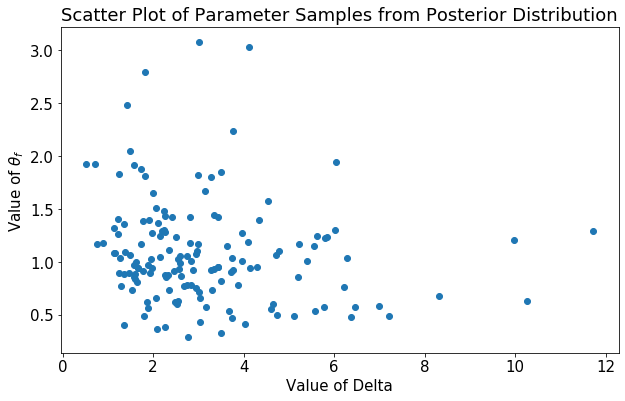

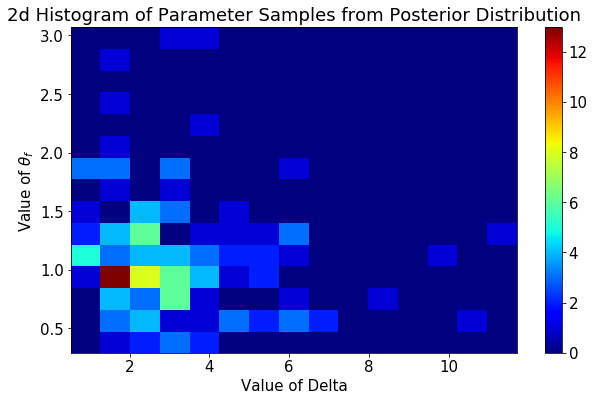

In [214]:
#2d scatterplot (maximum ascent would be where theta= delta *distance )
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10,6),)
ax.scatter(samples['delta'],samples['theta_f'])
ax.set(xlabel="Value of Delta",ylabel=r"Value of $\theta_f$",title="Scatter Plot of Parameter Samples from Posterior Distribution")

plt.show()

#pcolormesh
fig, ax = plt.subplots(figsize=(10,6),)
hist_2d= ax.hist2d(samples['delta'],samples['theta_f'],bins=(15,15) ,cmap=plt.cm.jet)
ax.set(xlabel="Value of Delta",ylabel=r"Value of $\theta_f$",title="2d Histogram of Parameter Samples from Posterior Distribution")
plt.colorbar(hist_2d[3],ax=ax)

plt.show()

#

#mu Median time series

In [100]:
#Grab quantiles and medians and plot them
mu_post_list_med=[]
for key in samples:
    if key.startswith("mu"):
        mu_post_list_med.append(samples.get(key))

        
mu_post_list_quant=[None]*len(mu_post_list_med)
for i in range(len(mu_post_list_med)):
    mu_post_list_quant[i]= np.quantile(mu_post_list_med[i],q=(.025,.975))
    mu_post_list_med[i]= np.median(mu_post_list_med[i])
    

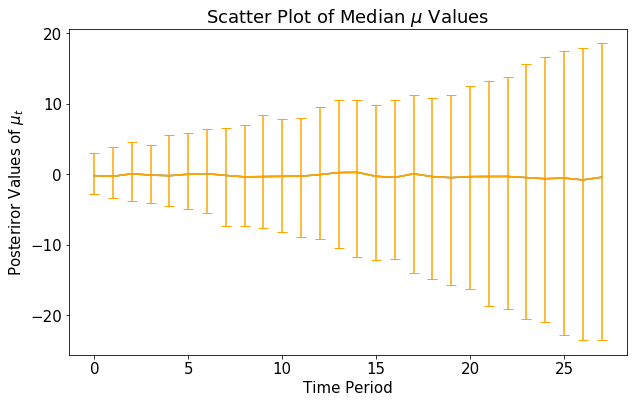

In [141]:
mpl_quant=np.array(mu_post_list_quant)

fig, ax = plt.subplots(figsize=(10,6),)
ax.plot(mu_post_list_med)
ax.set(ylabel=r"Posteriror Values of $\mu_t$",xlabel=r"Time Period",title=r"Scatter Plot of Median $\mu$ Values")

plotline, caplines, barlinecols=plt.errorbar(list(range(len(mu_post_list_med))),mu_post_list_med , 
             yerr=mpl_quant[:,1], lolims=True, 
             label='uplims=True',color='orange')
caplines[0].set_marker('_')
caplines[0].set_markersize(10)

plotline2, caplines2, barlinecols2=plt.errorbar(list(range(len(mu_post_list_med))),mu_post_list_med , 
             yerr=mpl_quant[:,0]*-1, uplims=True, 
             label='uplims=True',color='orange')
caplines2[0].set_marker('_')
caplines2[0].set_markersize(10)


plt.show()
